# AI for Predicting Age Specific Human Skeleton

## Transfer Learning - EffecientNetB5, ResNet101, Xception

### Importing Libraries

In [1]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf

2025-06-13 03:33:43.676125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749785623.896058      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749785623.959153      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preparation

In [2]:
# 📁 Paths
train_csv_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'
test_csv_path = '/kaggle/input/rsna-bone-age/boneage-test-dataset.csv'
train_img_dir = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
test_img_dir = '/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'

In [3]:
# 📄 Load CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
train_df.columns

Index(['id', 'boneage', 'male'], dtype='object')

In [5]:
train_df.describe()

,id,boneage
count,12611.000000,12611.000000
mean,8537.653001,127.320752
std,4108.763993,41.182021
min,1377.000000,1.000000
25%,5074.500000,96.000000
50%,8565.000000,132.000000
75%,12091.500000,156.000000
max,15610.000000,228.000000


In [6]:
test_df.columns

Index(['Case ID', 'Sex'], dtype='object')

In [7]:
# 🖼 Add image paths
train_df['path'] = train_df['id'].astype(str) + '.png'
test_df['path'] = test_df['Case ID'].astype(str) + '.png'

In [8]:
# 📊 Normalize target
mean_boneage = train_df['boneage'].mean()
std_boneage = train_df['boneage'].std()
train_df['boneage_z'] = (train_df['boneage'] - mean_boneage) / std_boneage

In [9]:
# 🔀 Train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.15, random_state=42)

### Data Augmentation

In [10]:
# 📈 Data Generator
class BoneAgeGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, img_size=224, batch_size=32, training=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.training = training
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, genders, labels = [], [], []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row['path'])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, 3, axis=-1)  # Convert to 3-channel RGB

            if self.augment:
                img = self.datagen.random_transform(img)

            images.append(img)
            genders.append(row['male'])
            if self.training:
                labels.append(row['boneage_z'])

        images = np.array(images)
        genders = np.array(genders).reshape(-1, 1)

        if self.training:
            return (images, genders), np.array(labels)
        else:
            return(images, genders)

### Model Training

In [11]:
# 📦 Data Generators
train_gen = BoneAgeGenerator(train_data, train_img_dir, augment=True)
val_gen = BoneAgeGenerator(val_data, train_img_dir, augment=False)

In [12]:
from tensorflow.keras.applications import EfficientNetB5, Xception, ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model

def build_boneage_model(backbone_name='EfficientNetB5', input_shape=(224, 224, 3)):
    # Define image and gender inputs
    image_input = Input(shape=input_shape, name='image_input')
    gender_input = Input(shape=(1,), name='gender_input')

    # Select backbone
    if backbone_name == 'EfficientNetB5':
        base_model = EfficientNetB5(include_top=False, weights='imagenet', input_tensor=image_input)
    elif backbone_name == 'Xception':
        base_model = Xception(include_top=False, weights='imagenet', input_tensor=image_input)
    elif backbone_name == 'ResNet101':
        base_model = ResNet101(include_top=False, weights='imagenet', input_tensor=image_input)
    else:
        raise ValueError("Unsupported model name. Choose from 'EfficientNetB5', 'Xception', 'ResNet101'.")

    # Feature extraction
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Concatenate gender
    x = Concatenate()([x, gender_input])

    # Dense layers
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='linear')(x)  # Regression output

    # Final model
    model = Model(inputs=[image_input, gender_input], outputs=output)
    return model

#### EfficientNetB5

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_eff = build_boneage_model('EfficientNetB5', input_shape=(224, 224, 3))

model_eff.compile(optimizer='adam', loss='mse', metrics=['mae'])

checkpoint = ModelCheckpoint("/kaggle/working/EfficientnetB5.keras", monitor='val_mae', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train
history_eff = model_eff.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50,
                    callbacks=[checkpoint, early_stop, reduce_lr])

I0000 00:00:1749785638.280777      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749785638.281479      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1749785785.566821      63 service.cc:148] XLA service 0x7da640004590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749785785.567894      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749785785.567919      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749785798.507646      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749785821.665533      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749785821.807013      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749785822.219087      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 65/335 ━━━━━━━━━━━━━━━━━━━━ 8:14 2s/step - loss: 0.7846 - mae: 0.7120

E0000 00:00:1749786025.450074      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749786025.590846      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749786025.966796      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749786026.112647      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749786026.538909      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.5121 - mae: 0.5556
Epoch 1: val_mae improved from inf to 0.64538, saving model to /kaggle/working/efficientnetb5_best.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 1012s 2s/step - loss: 0.5116 - mae: 0.5553 - val_loss: 0.6913 - val_mae: 0.6454 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1808 - mae: 0.3321
Epoch 2: val_mae did not improve from 0.64538
335/335 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - loss: 0.1808 - mae: 0.3321 - val_loss: 1.5094 - val_mae: 1.0558 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1299 - mae: 0.2800
Epoch 3: val_mae did not improve from 0.64538
335/335 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - loss: 0.1299 - mae: 0.2800 - val_loss: 1.2219 - val_mae: 0.8701 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1132 - mae: 0.2599
Epoch 4: val_mae did not improve from 0.64538

Epoch 4: ReduceLROnPlateau reducing learning rate 

##### Save the history

In [15]:
import pickle

# Save EfficientNetB0 training history
with open('history_eff.pkl', 'wb') as f:
    pickle.dump(history_eff.history, f)

#### Xception

In [ ]:
# Xception
model_xception = build_boneage_model('Xception', input_shape=(224, 224, 3))
model_xception.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_xcp = model_xception.fit(train_gen,
                   validation_data=val_gen,
                   epochs=50,
                   callbacks=[
                       ModelCheckpoint("/kaggle/working/Xception.keras", monitor='val_mae', save_best_only=True),
                       EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
                       ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                   ])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


E0000 00:00:1749795852.041182      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749795852.229848      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749795853.586592      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749795853.726708      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 60/335 ━━━━━━━━━━━━━━━━━━━━ 5:10 1s/step - loss: 0.7323 - mae: 0.6714

E0000 00:00:1749795951.504560      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749795951.692069      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749795952.901349      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749795953.041287      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


335/335 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - loss: 0.4171 - mae: 0.4819 - val_loss: 0.2675 - val_mae: 0.4092 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - loss: 0.1648 - mae: 0.3074 - val_loss: 0.1594 - val_mae: 0.3039 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - loss: 0.1390 - mae: 0.2841 - val_loss: 0.1700 - val_mae: 0.3080 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - loss: 0.1251 - mae: 0.2695 - val_loss: 0.1364 - val_mae: 0.2865 - learning_rate: 0.0010
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - loss: 0.1248 - mae: 0.2678 - val_loss: 0.1746 - val_mae: 0.3323 - learning_rate: 0.0010
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - loss: 0.1050 - mae: 0.2493 - val_loss: 0.0761 - val_mae: 0.2070 - learning_rate: 0.0010
Epoch 7/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - loss: 0.0973 - mae: 0.2395 - val_loss: 0.0750 - val_mae: 0.2133 - learning_rate: 0.0010
Epoch 8/50

##### Save the history

In [17]:
import pickle

# Save EfficientNetB0 training history
with open('history_xcp.pkl', 'wb') as f:
    pickle.dump(history_xcp.history, f)

#### ResNet101

In [ ]:
# ResNet101
history_res = model_resnet = build_boneage_model('ResNet101', input_shape=(224, 224, 3))
model_resnet.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_resnet.fit(train_gen,
                 validation_data=val_gen,
                 epochs=50,
                 callbacks=[
                     ModelCheckpoint("/kaggle/working/Resnet101.keras", monitor='val_mae', save_best_only=True),
                     EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
                     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
                 ])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 633s 1s/step - loss: 1.8212 - mae: 0.9362 - val_loss: 0.9991 - val_mae: 0.7877 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - loss: 0.8168 - mae: 0.7110 - val_loss: 1.3866 - val_mae: 0.8729 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - loss: 0.4089 - mae: 0.4712 - val_loss: 1.8283 - val_mae: 0.7170 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - loss: 0.3072 - mae: 0.4075 - val_loss: 0.7614 - val_mae: 0.6543 - learning_rate: 0.0010
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - loss: 0.2933 - mae: 0.4019 - val_loss: 0.3237 - val_mae: 0.4077 - learning_rate: 0.0010
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - loss: 0.2601 - mae: 0.3795 - val_loss: 0.1915 - val_mae: 0.3430 - learning_rate: 0.0010
Epoch 7/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - loss: 0.1894 - mae: 0.3287 - val_l

##### Save the history

In [ ]:
import pickle

# Save ResNet101 training history
with open('history_resnet.pkl', 'wb') as f:
    pickle.dump(history_res.history, f)

### Graphs Plotting

#### Load the Saved History

In [ ]:
import pickle

# Load the saved history
with open('/kaggle/input/rsna/keras/default/1/history_eff.pkl', 'rb') as f:
    history_eff = pickle.load(f)

with open('/kaggle/input/rsna/keras/default/1/history_xcp.pkl', 'rb') as f:
    history_xcp = pickle.load(f)

with open('/kaggle/input/rsna/keras/default/1/history_resnet.pkl', 'rb') as f:
    history_res = pickle.load(f)

#### Plot

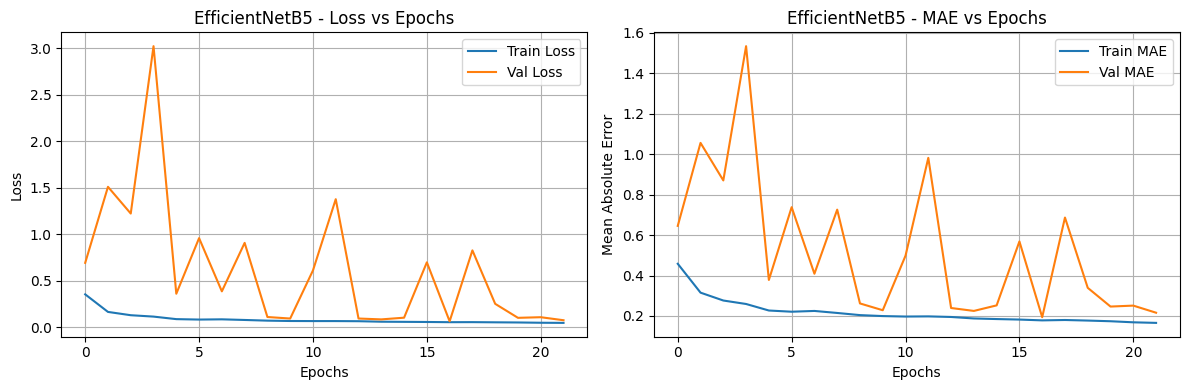

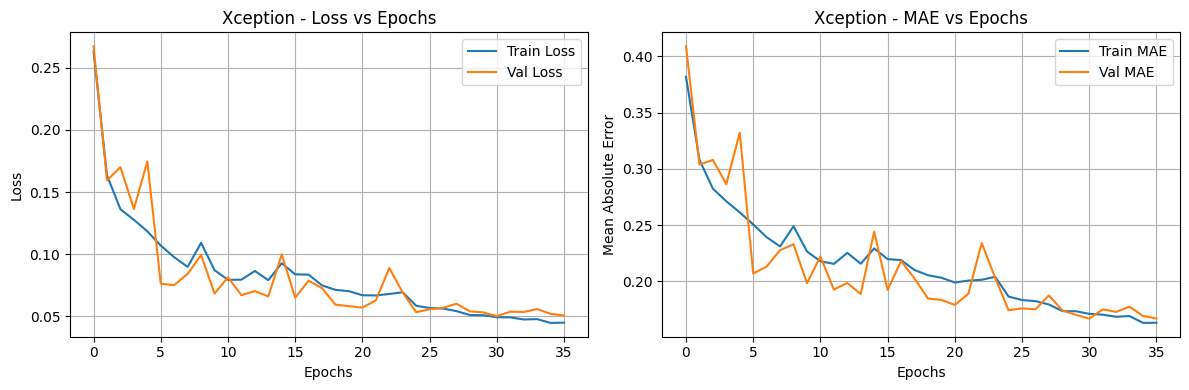

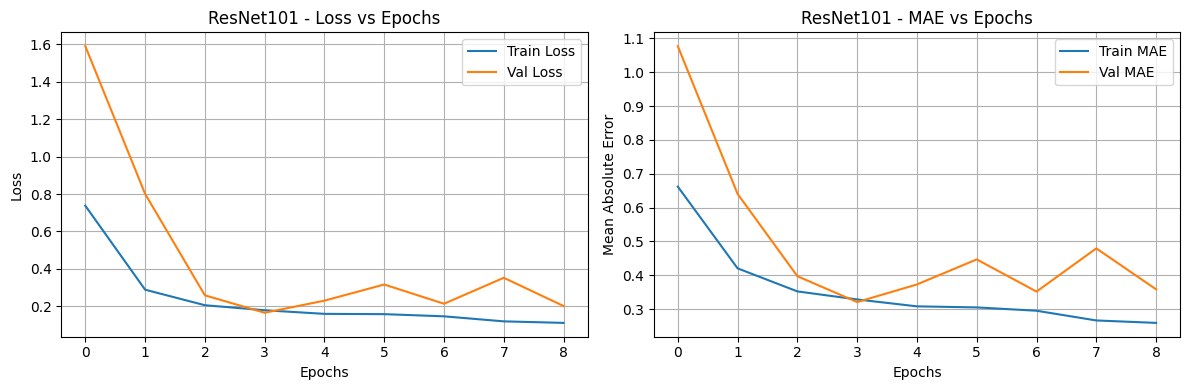

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name):
    # Plot Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history['mae'], label='Train MAE')
    plt.plot(history['val_mae'], label='Val MAE')
    plt.title(f'{model_name} - MAE vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example
plot_training_curves(history_eff, "EfficientNetB5")
plot_training_curves(history_xcp, "Xception")
plot_training_curves(history_res, "ResNet101")

### Performance Metrices

#### Load the Models

In [ ]:
from tensorflow.keras.models import load_model

model_eff = load_model("/kaggle/input/rsna/keras/default/1/EfficientnetB5.keras")  # or whatever path you used
model_res = load_model("/kaggle/input/rsna/keras/default/1/Resnet101.keras")  # or whatever path you used
model_xcp = load_model("/kaggle/input/rsna/keras/default/1/Xception.keras")  # or whatever path you used

I0000 00:00:1749888034.100567      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749888034.101245      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


##### EfficientNetB5

I0000 00:00:1749877088.294601     103 service.cc:148] XLA service 0x7946900061a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749877088.295977     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749877088.295999     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749877089.985040     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


I0000 00:00:1749877099.004550     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramet

📌 Classification Report of EfficentNetB5:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.80      0.57      0.67         7
           9       0.00      0.00      0.00         2
          10       0.80      0.44      0.57         9
          11       0.33      1.00      0.50         2
          12       1.00      0.50      0.67         2
          13       0.50      1.00      0.67         1
          14       0.75      0.75      0.75         4
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         1

    accuracy                           0.50        32
   macro avg       0.40      0.41      0.37        32
weighted avg       0.62      0.50      0.53        32



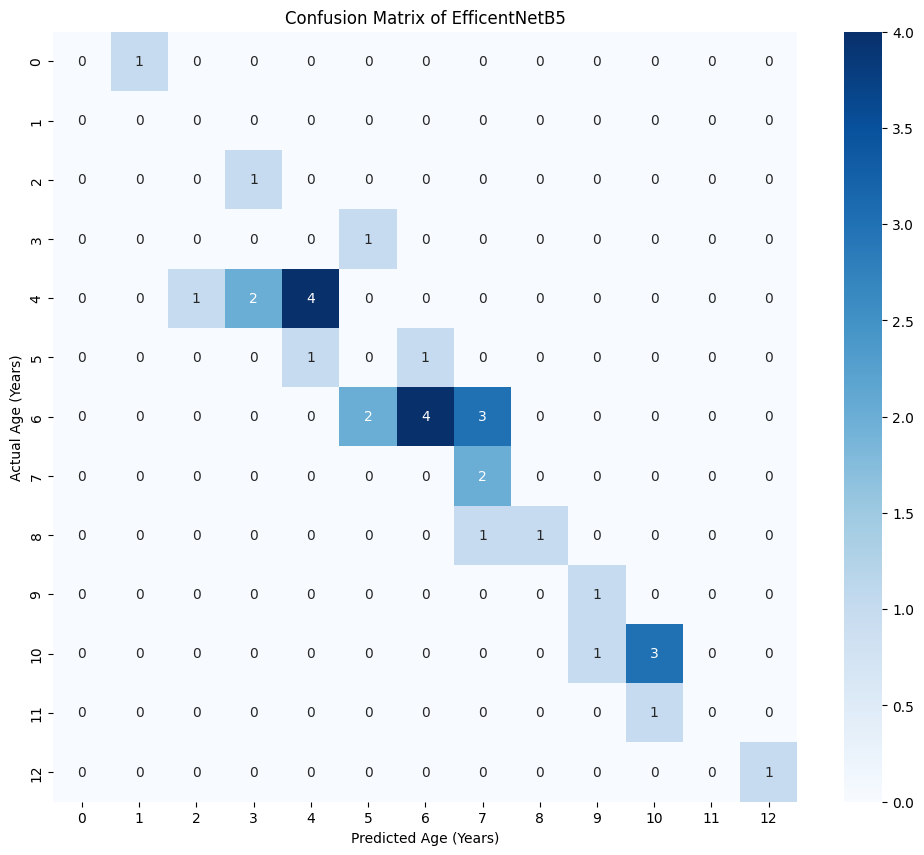

In [ ]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred = model_eff.predict((val_imgs, val_gender)).flatten()
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# 🎯 Convert to age classes (rounded to years)
y_true_cls = np.round(y_true / 12).astype(int)
y_pred_cls = np.round(y_pred / 12).astype(int)

# 📊 Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("📌 Classification Report of EfficentNetB5:")
print(classification_report(y_true_cls, y_pred_cls))

# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix of EfficentNetB5")
plt.show()

##### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
📌 Classification Report of Xcpetion:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       1.00      0.86      0.92         7
           9       0.33      0.50      0.40         2
          10       0.75      0.33      0.46         9
          11       0.29      1.00      0.44         2
          12       1.00      1.00      1.00         2
          13       0.33      1.00      0.50         1
          14       0.67      0.50      0.57         4
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         1

    accuracy                           0.59        32
   macro avg       0.53      0.60      0.53        32
weighted avg       0.69      0.59      0.60        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


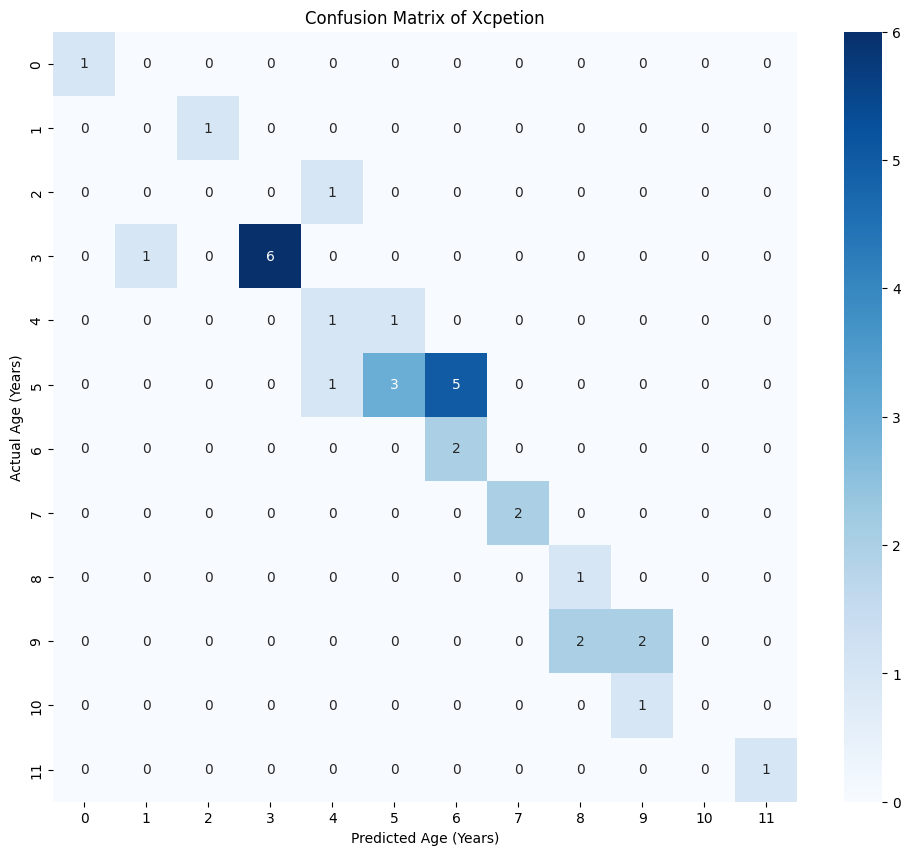

In [ ]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred = model_xcp.predict((val_imgs, val_gender)).flatten()
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# 🎯 Convert to age classes (rounded to years)
y_true_cls = np.round(y_true / 12).astype(int)
y_pred_cls = np.round(y_pred / 12).astype(int)

# 📊 Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("📌 Classification Report of Xcpetion:")
print(classification_report(y_true_cls, y_pred_cls))

# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix of Xcpetion")
plt.show()

##### ResNet101

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
📌 Classification Report of ResNet101:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       1.00      0.86      0.92         7
           9       0.33      0.50      0.40         2
          10       0.75      0.33      0.46         9
          11       0.29      1.00      0.44         2
          12       1.00      1.00      1.00         2
          13       0.33      1.00      0.50         1
          14       0.67      0.50      0.57         4
          15       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         1

    accuracy                           0.59        32
   macro avg       0.53      0.60      0.53        32
weighted avg       0.69      0.59      0.60        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


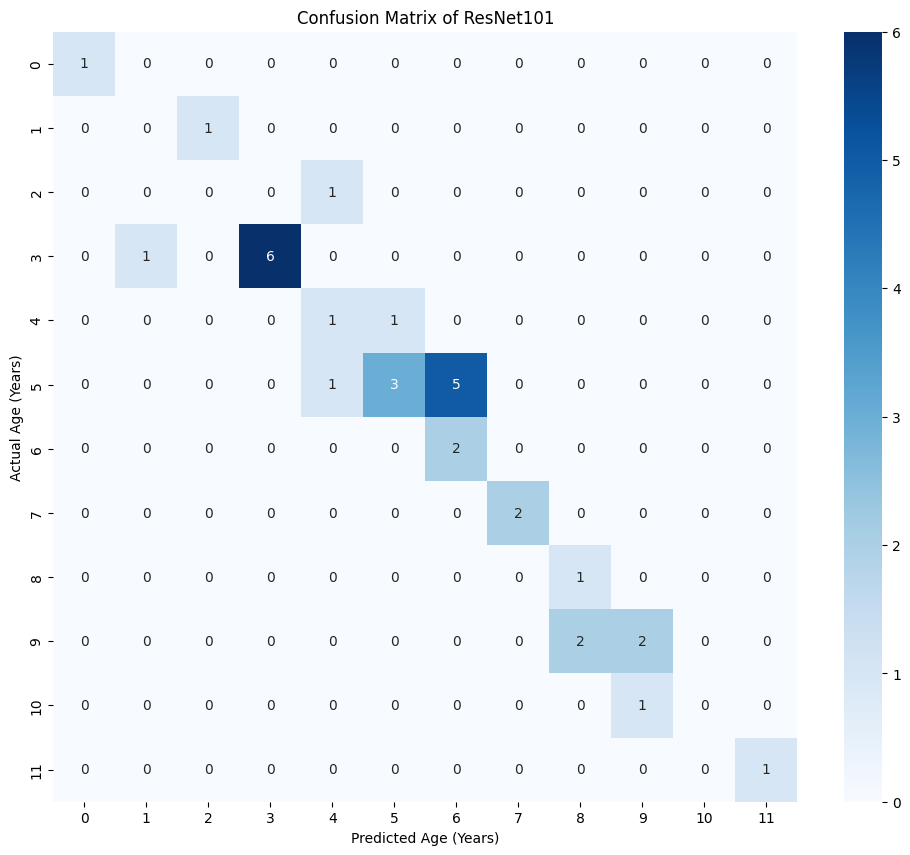

In [ ]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred = model_xcp.predict((val_imgs, val_gender)).flatten()
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# 🎯 Convert to age classes (rounded to years)
y_true_cls = np.round(y_true / 12).astype(int)
y_pred_cls = np.round(y_pred / 12).astype(int)

# 📊 Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("📌 Classification Report of ResNet101:")
print(classification_report(y_true_cls, y_pred_cls))

# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix of ResNet101")
plt.show()

#### Change of bins in the range  of the age 5 years

##### EfficientNetB5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
              precision    recall  f1-score   support

         0-5       1.00      1.00      1.00         1
       10-15       0.62      1.00      0.77        10
       15-20       1.00      1.00      1.00         1
        5-10       1.00      0.70      0.82        20

    accuracy                           0.81        32
   macro avg       0.91      0.93      0.90        32
weighted avg       0.88      0.81      0.82        32



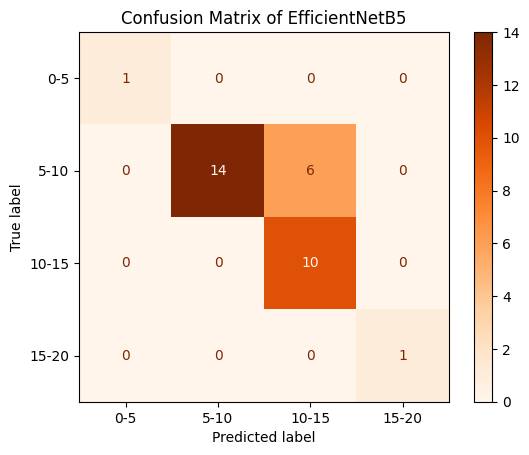

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd


# 🎯 Define bins and labels
bins = [0, 60, 120, 180, 240]
labels = ['0-5', '5-10', '10-15', '15-20']

# ✅ Get the batch
val_batch = val_gen[0]

# Extract input (2 inputs) and true output
X_input, y_true = val_batch  # X_input is a list: [images, gender]
val_imgs, val_gender = X_input

# 🧠 Predict
y_pred = model_eff.predict([val_imgs, val_gender]).flatten()

# 🔁 Un-normalize (if used in training)
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true.flatten() * std_boneage + mean_boneage

# Convert to categories
import pandas as pd
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📊 Report and Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true_cat, y_pred_cat))

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix of EfficientNetB5")
plt.grid(False)
plt.show()

##### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
              precision    recall  f1-score   support

         0-5       1.00      1.00      1.00         1
       10-15       0.56      1.00      0.71        10
       15-20       1.00      1.00      1.00         1
        5-10       1.00      0.60      0.75        20

    accuracy                           0.75        32
   macro avg       0.89      0.90      0.87        32
weighted avg       0.86      0.75      0.75        32



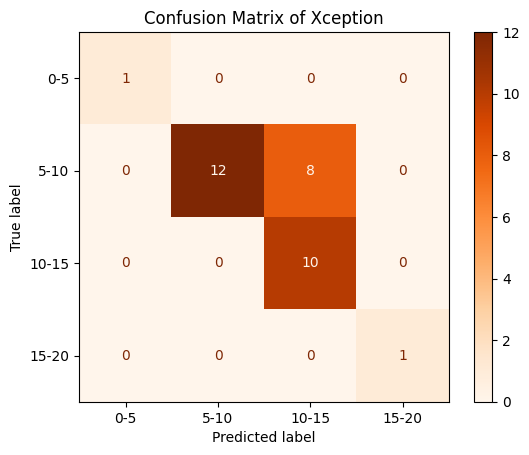

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd


# 🎯 Define bins and labels
bins = [0, 60, 120, 180, 240]
labels = ['0-5', '5-10', '10-15', '15-20']

# ✅ Get the batch
val_batch = val_gen[0]

# Extract input (2 inputs) and true output
X_input, y_true = val_batch  # X_input is a list: [images, gender]
val_imgs, val_gender = X_input

# 🧠 Predict
y_pred = model_xcp.predict([val_imgs, val_gender]).flatten()

# 🔁 Un-normalize (if used in training)
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true.flatten() * std_boneage + mean_boneage

# Convert to categories
import pandas as pd
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📊 Report and Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true_cat, y_pred_cat))

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix of Xception")
plt.grid(False)
plt.show()

##### ResNet101

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
              precision    recall  f1-score   support

         0-5       1.00      1.00      1.00         1
       10-15       0.53      1.00      0.69        10
       15-20       0.00      0.00      0.00         1
        5-10       1.00      0.60      0.75        20

    accuracy                           0.72        32
   macro avg       0.63      0.65      0.61        32
weighted avg       0.82      0.72      0.72        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


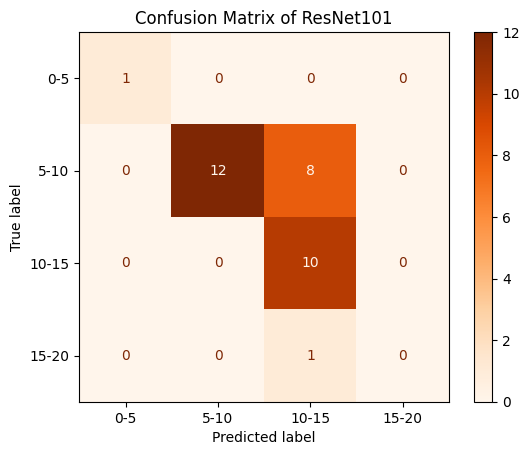

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd


# 🎯 Define bins and labels
bins = [0, 60, 120, 180, 240]
labels = ['0-5', '5-10', '10-15', '15-20']

# ✅ Get the batch
val_batch = val_gen[0]

# Extract input (2 inputs) and true output
X_input, y_true = val_batch  # X_input is a list: [images, gender]
val_imgs, val_gender = X_input

# 🧠 Predict
y_pred = model_res.predict([val_imgs, val_gender]).flatten()

# 🔁 Un-normalize (if used in training)
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true.flatten() * std_boneage + mean_boneage

# Convert to categories
import pandas as pd
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📊 Report and Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true_cat, y_pred_cat))

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix of ResNet101")
plt.grid(False)
plt.show()

#### Change of bins in the range  of the age 2 years

##### EfficientNetB5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
              precision    recall  f1-score   support

       10-12       0.33      0.75      0.46         4
       12-14       0.71      1.00      0.83         5
       14-16       1.00      0.50      0.67         2
         2-4       1.00      1.00      1.00         1
         4-6       0.00      0.00      0.00         1
         6-8       0.88      0.88      0.88         8
        8-10       0.83      0.45      0.59        11

    accuracy                           0.69        32
   macro avg       0.68      0.65      0.63        32
weighted avg       0.75      0.69      0.68        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


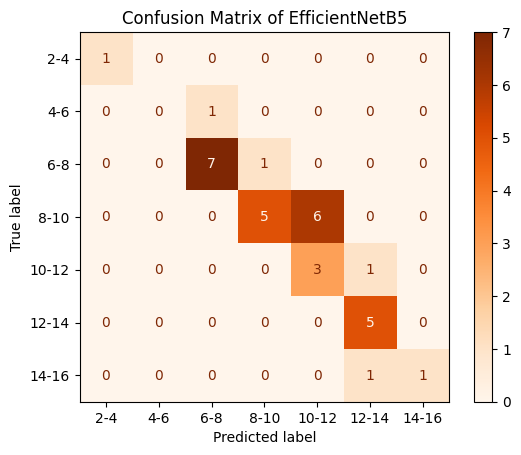

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd


# 🎯 Define bins and labels
bins = [24, 48, 72, 96, 120, 144, 168, 192]
labels = ['2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16',]

# ✅ Get the batch
val_batch = val_gen[0]

# Extract input (2 inputs) and true output
X_input, y_true = val_batch  # X_input is a list: [images, gender]
val_imgs, val_gender = X_input

# 🧠 Predict
y_pred = model_eff.predict([val_imgs, val_gender]).flatten()

# 🔁 Un-normalize (if used in training)
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true.flatten() * std_boneage + mean_boneage

# Convert to categories
import pandas as pd
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📊 Report and Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true_cat, y_pred_cat))

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix of EfficientNetB5")
plt.grid(False)
plt.show()

##### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
              precision    recall  f1-score   support

       10-12       0.33      1.00      0.50         4
       12-14       1.00      0.80      0.89         5
       14-16       0.67      1.00      0.80         2
         2-4       1.00      1.00      1.00         1
         4-6       0.00      0.00      0.00         1
         6-8       0.80      0.50      0.62         8
        8-10       0.43      0.27      0.33        11

    accuracy                           0.56        32
   macro avg       0.60      0.65      0.59        32
weighted avg       0.62      0.56      0.55        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


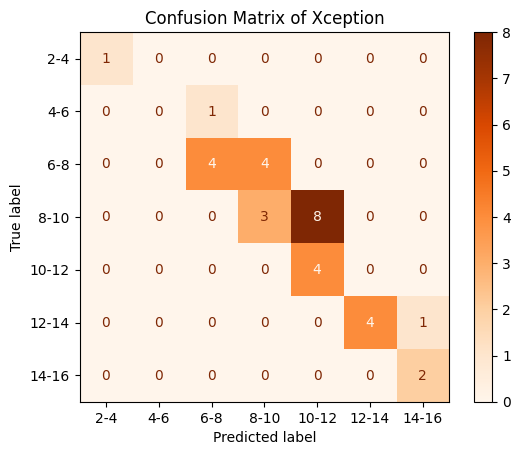

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd


# 🎯 Define bins and labels
bins = [24, 48, 72, 96, 120, 144, 168, 192]
labels = ['2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16',]

# ✅ Get the batch
val_batch = val_gen[0]

# Extract input (2 inputs) and true output
X_input, y_true = val_batch  # X_input is a list: [images, gender]
val_imgs, val_gender = X_input

# 🧠 Predict
y_pred = model_xcp.predict([val_imgs, val_gender]).flatten()

# 🔁 Un-normalize (if used in training)
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true.flatten() * std_boneage + mean_boneage

# Convert to categories
import pandas as pd
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📊 Report and Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true_cat, y_pred_cat))

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix of Xception")
plt.grid(False)
plt.show()

##### ResNet101

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
              precision    recall  f1-score   support

       10-12       0.11      0.25      0.15         4
       12-14       0.50      0.80      0.62         5
       14-16       0.50      0.50      0.50         2
         2-4       1.00      1.00      1.00         1
         4-6       0.00      0.00      0.00         1
         6-8       0.71      0.62      0.67         8
        8-10       0.40      0.18      0.25        11

    accuracy                           0.44        32
   macro avg       0.46      0.48      0.46        32
weighted avg       0.47      0.44      0.43        32



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


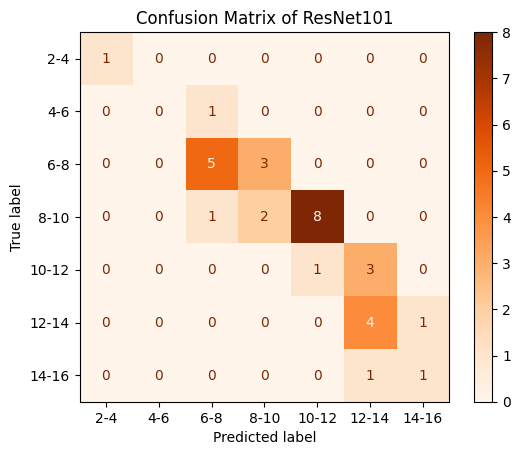

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd


# 🎯 Define bins and labels
bins = [24, 48, 72, 96, 120, 144, 168, 192]
labels = ['2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16']

# ✅ Get the batch
val_batch = val_gen[0]

# Extract input (2 inputs) and true output
X_input, y_true = val_batch  # X_input is a list: [images, gender]
val_imgs, val_gender = X_input

# 🧠 Predict
y_pred = model_res.predict([val_imgs, val_gender]).flatten()

# 🔁 Un-normalize (if used in training)
y_pred = y_pred * std_boneage + mean_boneage
y_true = y_true.flatten() * std_boneage + mean_boneage

# Convert to categories
import pandas as pd
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📊 Report and Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true_cat, y_pred_cat))

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Oranges')
plt.title("Confusion Matrix of ResNet101")
plt.grid(False)
plt.show()

#### On Complete Validation Set

##### EfficientNetB5

In [ ]:
# 🔁 Accumulate predictions and ground truths across all batches
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model_eff.predict((imgs, genders)).flatten()

    # Unnormalize
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

I0000 00:00:1749888065.158490     100 service.cc:148] XLA service 0x7cd5d0005e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749888065.159246     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749888065.159266     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749888066.711368     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


I0000 00:00:1749888074.938902     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

📌 Classification Report (Full Validation Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.12      0.22         8
           2       0.38      0.20      0.26        25
           3       0.30      0.19      0.24        36
           4       0.31      0.27      0.29        48
           5       0.23      0.29      0.25        49
           6       0.45      0.43      0.44        97
           7       0.38      0.45      0.41        99
           8       0.45      0.58      0.51       142
           9       0.34      0.43      0.38       124
          10       0.46      0.37      0.41       186
          11       0.32      0.48      0.39       144
          12       0.58      0.47      0.52       294
          13       0.38      0.54      0.45       183
          14       0.75      0.45      0.56       262
          15       0.43      0.50      0.46        72
          16       0.54      0.42 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


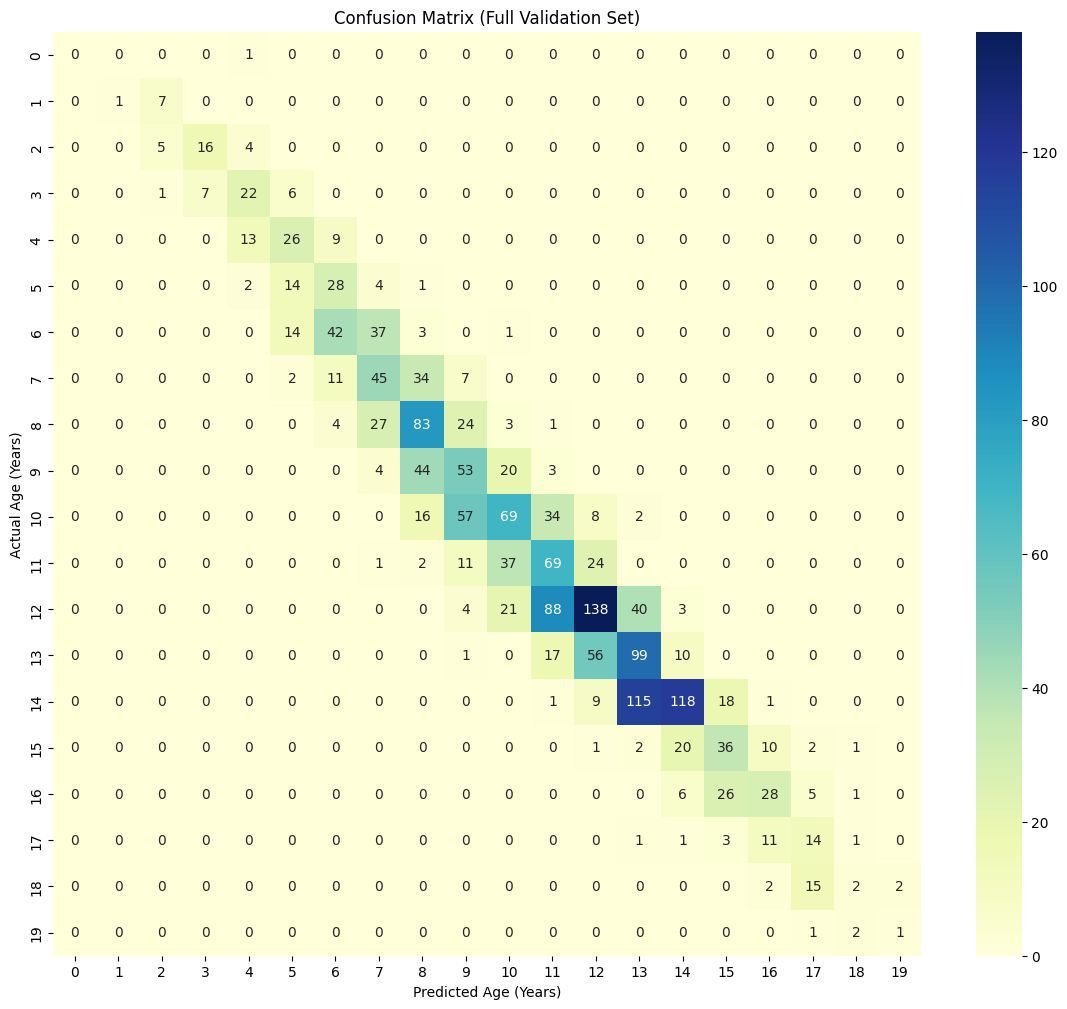

In [ ]:
# 🎯 Convert to age classes (rounded to nearest year)
y_true_cls = np.round(np.array(all_y_true) / 12).astype(int)
y_pred_cls = np.round(np.array(all_y_pred) / 12).astype(int)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📝 Report
print("📌 Classification Report (Full Validation Set):")
print(classification_report(y_true_cls, y_pred_cls))

# 🔷 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix (Full Validation Set)")
plt.show()

📌 Classification Report (EfficientNetB5 - Age Bins):
              precision    recall  f1-score   support

         2-4       0.57      0.47      0.51        62
         4-6       0.69      0.55      0.61       159
         6-8       0.63      0.70      0.66       238
        8-10       0.61      0.68      0.64       298
       10-12       0.61      0.66      0.63       362
       12-14       0.82      0.73      0.78       533
       14-16       0.66      0.75      0.70       149

   micro avg       0.68      0.68      0.68      1801
   macro avg       0.66      0.65      0.65      1801
weighted avg       0.68      0.68      0.68      1801

🎯 Age Group Classification Accuracy: 68.23


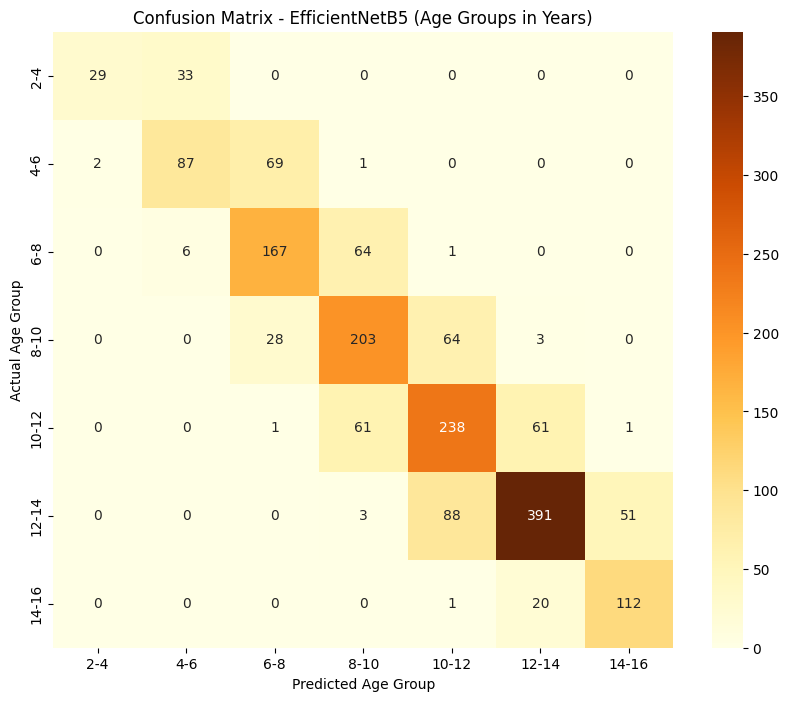

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define bins and labels (age in months)
bins = [24, 48, 72, 96, 120, 144, 168, 192]  # in months
labels = ['2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16']

# ✅ Convert to Pandas Series
y_true = pd.Series(all_y_true)
y_pred = pd.Series(all_y_pred)

# 📦 Bin the ages into defined age groups
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📝 Classification Report
print("📌 Classification Report (EfficientNetB5 - Age Bins):")
print(classification_report(
    y_true_cat.astype(str),
    y_pred_cat.astype(str),
    labels=labels,
    target_names=labels,
    zero_division=0
))

# ✅ Accuracy
accuracy = accuracy_score(y_true_cat.astype(str), y_pred_cat.astype(str))
print(f"🎯 Age Group Classification Accuracy: {accuracy*100:.2f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cat.astype(str), y_pred_cat.astype(str), labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Age Group")
plt.ylabel("Actual Age Group")
plt.title("Confusion Matrix - EfficientNetB5 (Age Groups in Years)")
plt.grid(False)
plt.show()

📌 Classification Report (EfficientNetB5 - Age Bins):
              precision    recall  f1-score   support

         0-5       0.98      0.63      0.77       167
        5-10       0.81      0.89      0.85       617
       10-15       0.91      0.90      0.91       986
       15-20       0.77      0.88      0.82       122

    accuracy                           0.87      1892
   macro avg       0.87      0.82      0.84      1892
weighted avg       0.88      0.87      0.87      1892

🎯 Age Group Classification Accuracy: 87.10


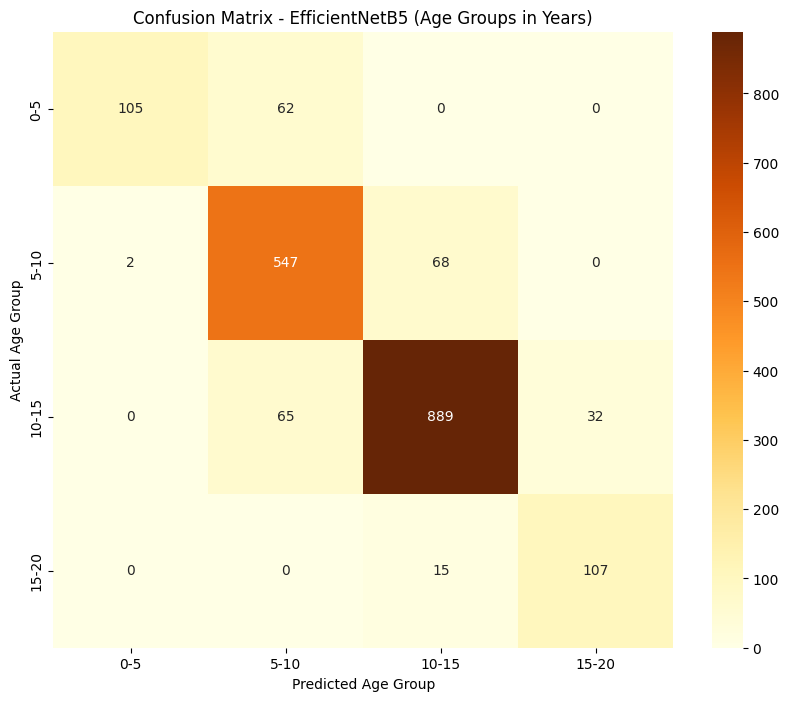

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define bins and labels
bins = [0, 60, 120, 180, 240]
labels = ['0-5', '5-10', '10-15', '15-20']

# ✅ Convert to Pandas Series
y_true = pd.Series(all_y_true)
y_pred = pd.Series(all_y_pred)

# 📦 Bin the ages into defined age groups
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📝 Classification Report
print("📌 Classification Report (EfficientNetB5 - Age Bins):")
print(classification_report(
    y_true_cat.astype(str),
    y_pred_cat.astype(str),
    labels=labels,
    target_names=labels,
    zero_division=0
))

# ✅ Accuracy
accuracy = accuracy_score(y_true_cat.astype(str), y_pred_cat.astype(str))
print(f"🎯 Age Group Classification Accuracy: {accuracy*100:.2f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cat.astype(str), y_pred_cat.astype(str), labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Age Group")
plt.ylabel("Actual Age Group")
plt.title("Confusion Matrix - EfficientNetB5 (Age Groups in Years)")
plt.grid(False)
plt.show()

##### Xception

In [ ]:
# 🔁 Accumulate predictions and ground truths across all batches
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model_xcp.predict((imgs, genders)).flatten()

    # Unnormalize
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

2025-06-14 08:02:55.190841: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,2048,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1536,7,7]{3,2,1,0}, f32[2048,1536,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-14 08:02:55.363331: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.172687529s
Trying algorithm eng3{k11=0} for conv (f32[32,2048,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1536,7,7]{3,2,1,0}, f32[2048,1536,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

📌 Classification Report (Full Validation Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.71      0.62      0.67         8
           2       0.57      0.52      0.54        25
           3       0.66      0.53      0.58        36
           4       0.63      0.54      0.58        48
           5       0.39      0.53      0.45        49
           6       0.55      0.45      0.50        97
           7       0.42      0.46      0.44        99
           8       0.50      0.46      0.48       142
           9       0.42      0.43      0.42       124
          10       0.48      0.46      0.47       186
          11       0.33      0.50      0.39       144
          12       0.63      0.51      0.56       294
          13       0.40      0.62      0.49       183
          14       0.79      0.51      0.62       262
          15       0.49      0.50      0.50        72
          16       0.54      0.38 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

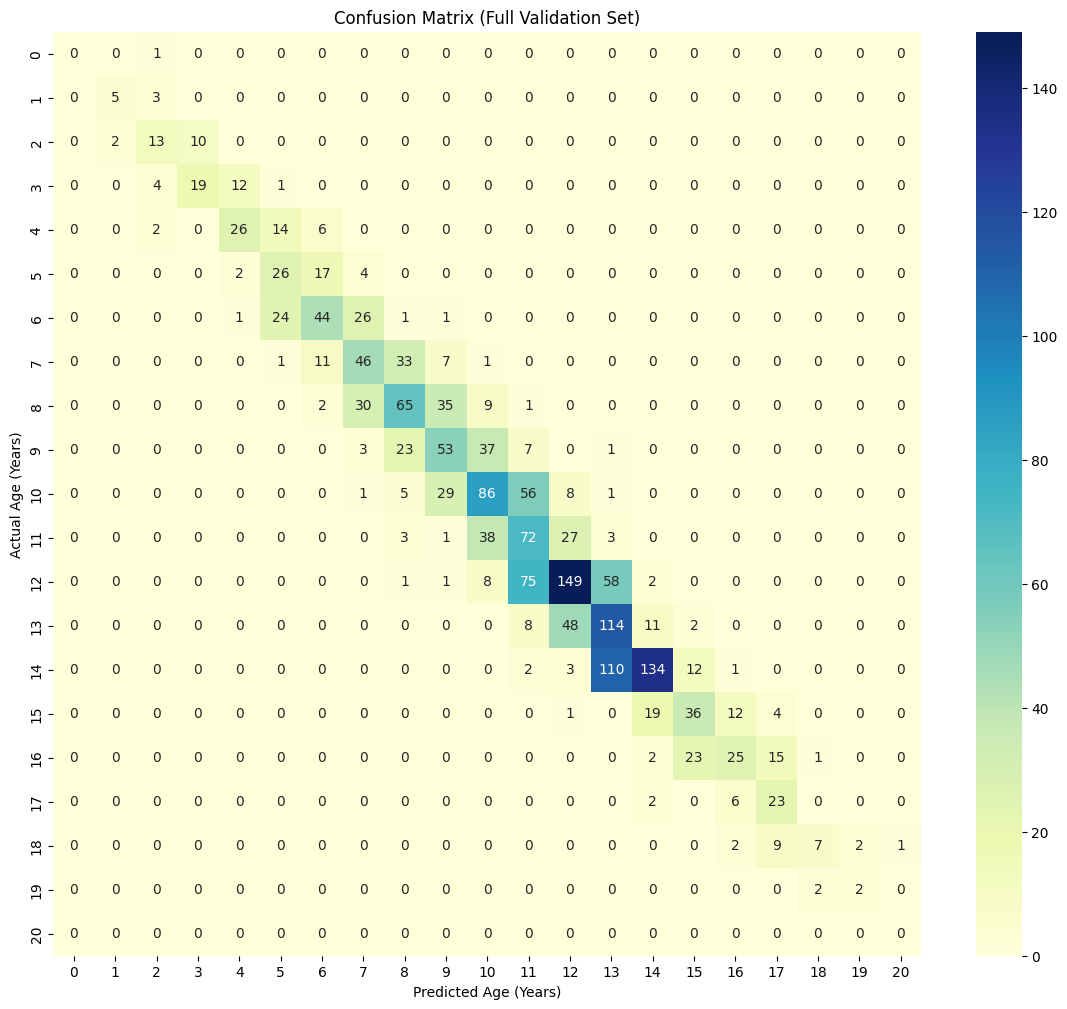

In [ ]:
# 🎯 Convert to age classes (rounded to nearest year)
y_true_cls = np.round(np.array(all_y_true) / 12).astype(int)
y_pred_cls = np.round(np.array(all_y_pred) / 12).astype(int)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📝 Report
print("📌 Classification Report (Full Validation Set):")
print(classification_report(y_true_cls, y_pred_cls))

# 🔷 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix (Full Validation Set)")
plt.show()

📌 Classification Report (EfficientNetB5 - Age Bins):
              precision    recall  f1-score   support

         2-4       0.77      0.71      0.74        62
         4-6       0.79      0.68      0.73       159
         6-8       0.69      0.59      0.64       238
        8-10       0.63      0.56      0.59       298
       10-12       0.61      0.77      0.68       362
       12-14       0.84      0.81      0.82       533
       14-16       0.72      0.77      0.75       149

   micro avg       0.72      0.71      0.71      1801
   macro avg       0.72      0.70      0.71      1801
weighted avg       0.72      0.71      0.71      1801

🎯 Age Group Classification Accuracy: 71.83


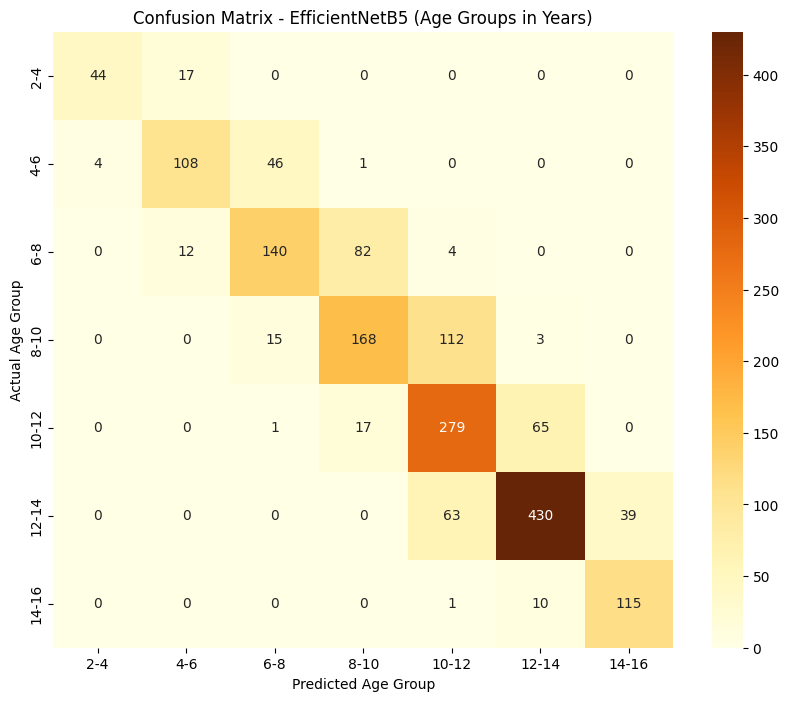

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define bins and labels (age in months)
bins = [24, 48, 72, 96, 120, 144, 168, 192]  # in months
labels = ['2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16']

# ✅ Convert to Pandas Series
y_true = pd.Series(all_y_true)
y_pred = pd.Series(all_y_pred)

# 📦 Bin the ages into defined age groups
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📝 Classification Report
print("📌 Classification Report (EfficientNetB5 - Age Bins):")
print(classification_report(
    y_true_cat.astype(str),
    y_pred_cat.astype(str),
    labels=labels,
    target_names=labels,
    zero_division=0
))

# ✅ Accuracy
accuracy = accuracy_score(y_true_cat.astype(str), y_pred_cat.astype(str))
print(f"🎯 Age Group Classification Accuracy: {accuracy*100:.2f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cat.astype(str), y_pred_cat.astype(str), labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Age Group")
plt.ylabel("Actual Age Group")
plt.title("Confusion Matrix - EfficientNetB5 (Age Groups in Years)")
plt.grid(False)
plt.show()

📌 Classification Report (Xception - Age Bins):
              precision    recall  f1-score   support

         0-5       0.93      0.71      0.81       167
        5-10       0.88      0.79      0.83       617
       10-15       0.88      0.94      0.91       986
       15-20       0.73      0.90      0.81       122

    accuracy                           0.87      1892
   macro avg       0.85      0.84      0.84      1892
weighted avg       0.87      0.87      0.87      1892

🎯 Age Group Classification Accuracy: 86.95


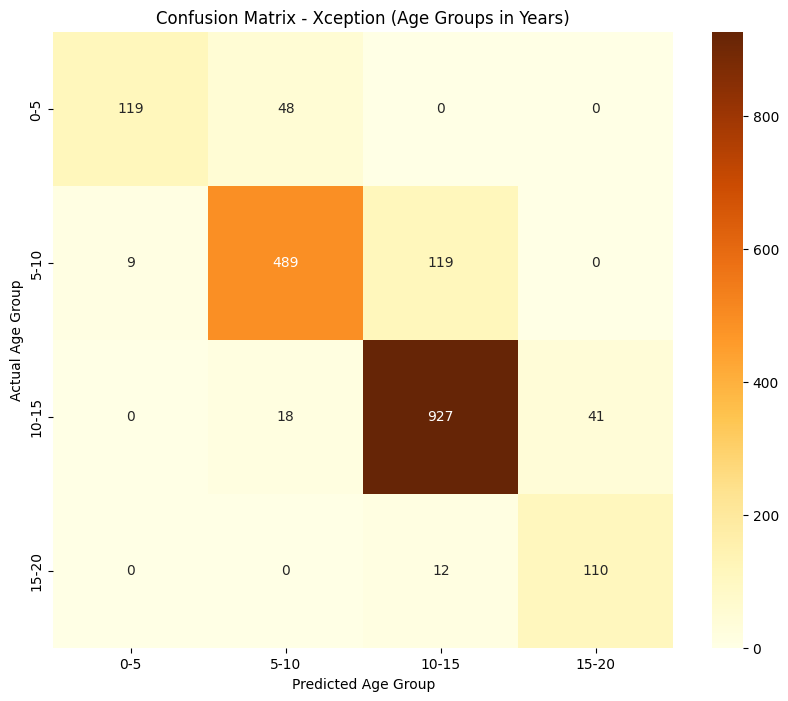

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define bins and labels
bins = [0, 60, 120, 180, 240]
labels = ['0-5', '5-10', '10-15', '15-20']

# ✅ Convert to Pandas Series
y_true = pd.Series(all_y_true)
y_pred = pd.Series(all_y_pred)

# 📦 Bin the ages into defined age groups
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📝 Classification Report
print("📌 Classification Report (Xception - Age Bins):")
print(classification_report(
    y_true_cat.astype(str),
    y_pred_cat.astype(str),
    labels=labels,
    target_names=labels,
    zero_division=0
))

# ✅ Accuracy
accuracy = accuracy_score(y_true_cat.astype(str), y_pred_cat.astype(str))
print(f"🎯 Age Group Classification Accuracy: {accuracy*100:.2f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cat.astype(str), y_pred_cat.astype(str), labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Age Group")
plt.ylabel("Actual Age Group")
plt.title("Confusion Matrix - Xception (Age Groups in Years)")
plt.grid(False)
plt.show()

##### ResNet101

In [ ]:
# 🔁 Accumulate predictions and ground truths across all batches
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model_res.predict((imgs, genders)).flatten()

    # Unnormalize
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

📌 Classification Report (Full Validation Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.25      0.29         8
           2       0.50      0.52      0.51        25
           3       0.46      0.33      0.39        36
           4       0.42      0.38      0.40        48
           5       0.27      0.41      0.32        49
           6       0.44      0.36      0.40        97
           7       0.41      0.45      0.43        99
           8       0.46      0.40      0.43       142
           9       0.41      0.43      0.42       124
          10       0.44      0.41      0.43       186
          11       0.34      0.46      0.39       144
          12       0.55      0.47      0.51       294
          13       0.38      0.58      0.46       183
          14       0.73      0.55      0.62       262
          15       0.33      0.43      0.38        72
          16       0.49      0.32 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


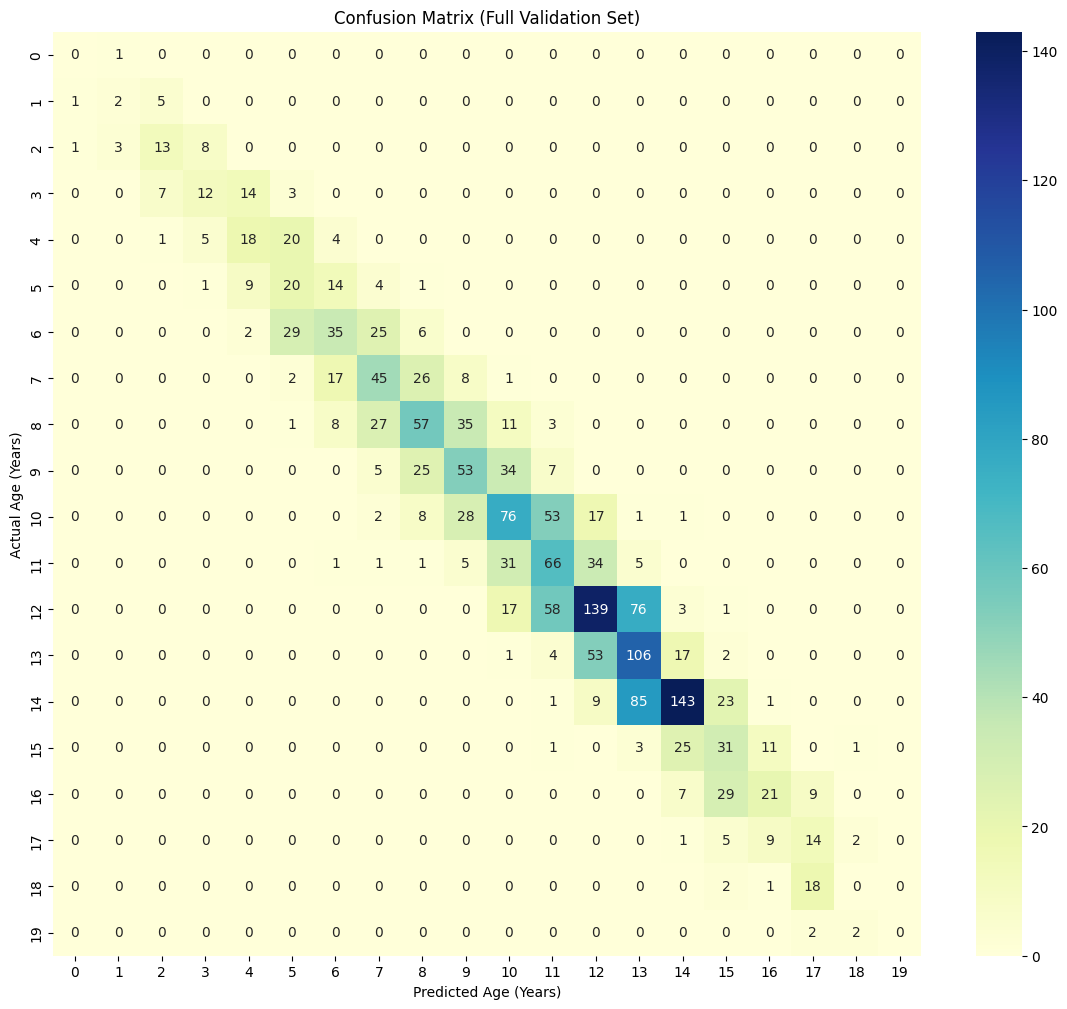

In [ ]:
# 🎯 Convert to age classes (rounded to nearest year)
y_true_cls = np.round(np.array(all_y_true) / 12).astype(int)
y_pred_cls = np.round(np.array(all_y_pred) / 12).astype(int)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📝 Report
print("📌 Classification Report (Full Validation Set):")
print(classification_report(y_true_cls, y_pred_cls))

# 🔷 Confusion Matrix
conf_matrix = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted Age (Years)")
plt.ylabel("Actual Age (Years)")
plt.title("Confusion Matrix (Full Validation Set)")
plt.show()

📌 Classification Report (EfficientNetB5 - Age Bins):
              precision    recall  f1-score   support

         2-4       0.71      0.66      0.68        62
         4-6       0.78      0.66      0.72       159
         6-8       0.65      0.62      0.63       238
        8-10       0.60      0.51      0.55       298
       10-12       0.60      0.68      0.64       362
       12-14       0.79      0.80      0.79       533
       14-16       0.62      0.79      0.70       149

   micro avg       0.68      0.68      0.68      1801
   macro avg       0.68      0.67      0.67      1801
weighted avg       0.68      0.68      0.68      1801

🎯 Age Group Classification Accuracy: 68.66


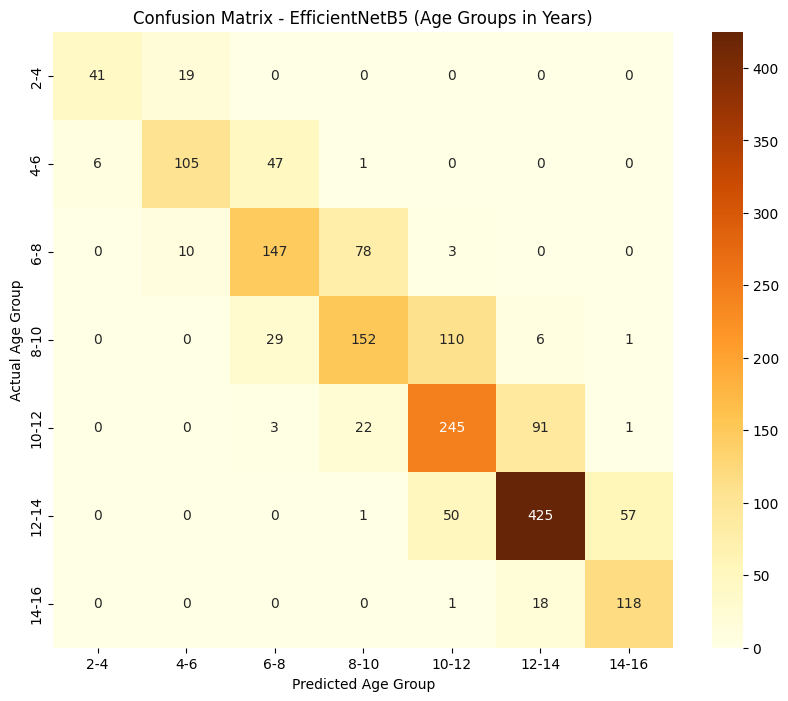

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define bins and labels (age in months)
bins = [24, 48, 72, 96, 120, 144, 168, 192]  # in months
labels = ['2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16']

# ✅ Convert to Pandas Series
y_true = pd.Series(all_y_true)
y_pred = pd.Series(all_y_pred)

# 📦 Bin the ages into defined age groups
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📝 Classification Report
print("📌 Classification Report (ResNet101 - Age Bins):")
print(classification_report(
    y_true_cat.astype(str),
    y_pred_cat.astype(str),
    labels=labels,
    target_names=labels,
    zero_division=0
))

# ✅ Accuracy
accuracy = accuracy_score(y_true_cat.astype(str), y_pred_cat.astype(str))
print(f"🎯 Age Group Classification Accuracy: {accuracy*100:.2f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cat.astype(str), y_pred_cat.astype(str), labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Age Group")
plt.ylabel("Actual Age Group")
plt.title("Confusion Matrix - ResNet101 (Age Groups in Years)")
plt.grid(False)
plt.show()

📌 Classification Report (ResNet101 - Age Bins):
              precision    recall  f1-score   support

         0-5       0.93      0.75      0.83       167
        5-10       0.88      0.79      0.83       617
       10-15       0.87      0.94      0.90       986
       15-20       0.74      0.83      0.78       122

   micro avg       0.87      0.87      0.87      1892
   macro avg       0.85      0.83      0.84      1892
weighted avg       0.87      0.87      0.86      1892

🎯 Age Group Classification Accuracy: 86.58


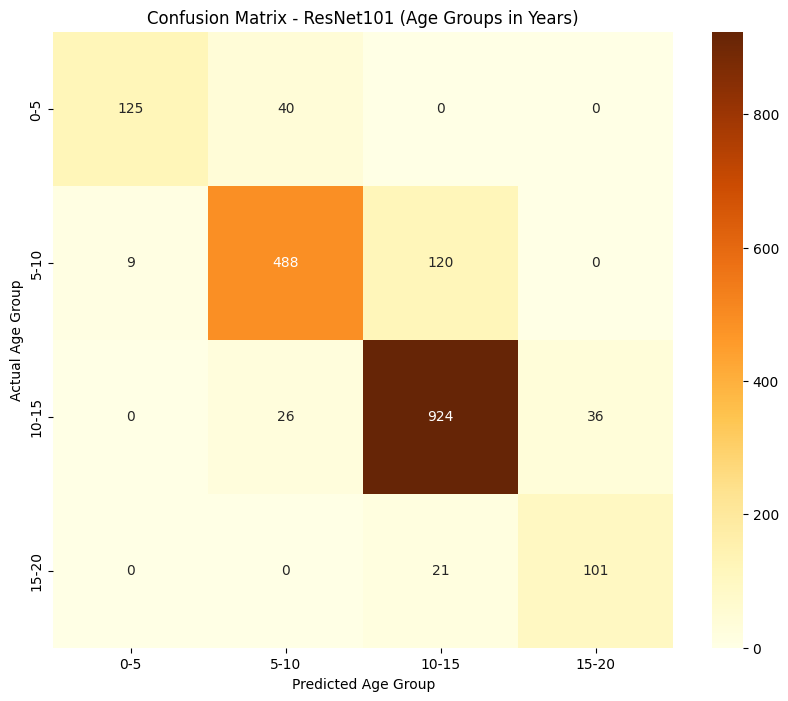

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Define bins and labels
bins = [0, 60, 120, 180, 240]
labels = ['0-5', '5-10', '10-15', '15-20']

# ✅ Convert to Pandas Series
y_true = pd.Series(all_y_true)
y_pred = pd.Series(all_y_pred)

# 📦 Bin the ages into defined age groups
y_true_cat = pd.cut(y_true, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)

# 📝 Classification Report
print("📌 Classification Report (ResNet101 - Age Bins):")
print(classification_report(
    y_true_cat.astype(str),
    y_pred_cat.astype(str),
    labels=labels,
    target_names=labels,
    zero_division=0
))

# ✅ Accuracy
accuracy = accuracy_score(y_true_cat.astype(str), y_pred_cat.astype(str))
print(f"🎯 Age Group Classification Accuracy: {accuracy*100:.2f}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true_cat.astype(str), y_pred_cat.astype(str), labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Age Group")
plt.ylabel("Actual Age Group")
plt.title("Confusion Matrix - ResNet101 (Age Groups in Years)")
plt.grid(False)
plt.show()

## Regression Model Using Transfer Learning

### Preliminaries (Preprocessing & Loading CSVs)

In [ ]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as t

2025-06-13 02:30:39.425362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749781839.631218      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749781839.689493      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# 📁 Paths
train_csv_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset.csv'
test_csv_path = '/kaggle/input/rsna-bone-age/boneage-test-dataset.csv'
train_img_dir = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
test_img_dir = '/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'

In [ ]:
# 📄 Load CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [ ]:
train_df.columns

Index(['id', 'boneage', 'male'], dtype='object')

In [ ]:
test_df.columns

Index(['Case ID', 'Sex'], dtype='object')

In [ ]:
# 🖼 Add image paths
train_df['path'] = train_df['id'].astype(str) + '.png'
test_df['path'] = test_df['Case ID'].astype(str) + '.png'

In [ ]:
# 📊 Normalize target
mean_boneage = train_df['boneage'].mean()
std_boneage = train_df['boneage'].std()
train_df['boneage_z'] = (train_df['boneage'] - mean_boneage) / std_boneage

In [ ]:
# 🔀 Train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

### 🧹 Data Generator

In [ ]:
# 📈 Data Generator
class BoneAgeGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, img_size=224, batch_size=32, training=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.training = training
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        ) if augment else None

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, genders, labels = [], [], []

        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.img_dir, row['path'])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)
            img = np.repeat(img, 3, axis=-1)  # Convert to 3-channel RGB

            if self.augment:
                img = self.datagen.random_transform(img)

            images.append(img)
            genders.append(row['male'])
            if self.training:
                labels.append(row['boneage_z'])

        images = np.array(images)
        genders = np.array(genders).reshape(-1, 1)

        if self.training:
            return (images, genders), np.array(labels)
        else:
            return(images, genders)

### 🧠 Model Training

In [ ]:
# 📦 Data Generators
train_gen = BoneAgeGenerator(train_data, train_img_dir, augment=True)
val_gen = BoneAgeGenerator(val_data, train_img_dir, augment=False)

In [ ]:
from tensorflow.keras.applications import EfficientNetB5, Xception, ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError

def build_model(backbone_name='EfficientNetB5', input_shape=(224, 224, 3)):
    image_input = Input(shape=input_shape, name='image_input')
    gender_input = Input(shape=(1,), name='gender_input')

    # Backbone selection
    if backbone_name == 'EfficientNetB5':
        base_model = EfficientNetB5(include_top=False, weights='imagenet', input_tensor=image_input)
    elif backbone_name == 'Xception':
        base_model = Xception(include_top=False, weights='imagenet', input_tensor=image_input)
    elif backbone_name == 'ResNet101':
        base_model = ResNet101(include_top=False, weights='imagenet', input_tensor=image_input)
    else:
        raise ValueError("Invalid model name")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Concatenate()([x, gender_input])
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[image_input, gender_input], outputs=output)

    model.compile(optimizer='adam', loss='mse', metrics=['mae', RootMeanSquaredError(name='rmse')])
    return model

#### EfficientNetB5

In [ ]:
#EfficientNetB5
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
    ModelCheckpoint("/kaggle/working/EfficientNetB5_reg.keras", monitor='val_mae', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

model_eff = build_model(backbone_name='EfficientNetB5')
history_eff = model_eff.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

I0000 00:00:1749781851.796362      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749781851.797033      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1749781988.700330      63 service.cc:148] XLA service 0x799d34003a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749781988.701221      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749781988.701245      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749782000.866079      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749782020.839370      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749782020.980839      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749782021.391546      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

251/335 ━━━━━━━━━━━━━━━━━━━━ 2:06 2s/step - loss: 0.5672 - mae: 0.5828 - rmse: 0.7439

E0000 00:00:1749782475.081084      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749782475.222716      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749782475.572519      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749782475.716822      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749782476.086906      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

335/335 ━━━━━━━━━━━━━━━━━━━━ 884s 2s/step - loss: 0.5140 - mae: 0.5516 - rmse: 0.7069 - val_loss: 1.6888 - val_mae: 1.0703 - val_rmse: 1.2995 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - loss: 0.1655 - mae: 0.3163 - rmse: 0.4069 - val_loss: 4.7819 - val_mae: 1.9795 - val_rmse: 2.1868 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - loss: 0.1375 - mae: 0.2882 - rmse: 0.3706 - val_loss: 1.5454 - val_mae: 0.9912 - val_rmse: 1.2431 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - loss: 0.1115 - mae: 0.2592 - rmse: 0.3339 - val_loss: 4.8511 - val_mae: 1.9958 - val_rmse: 2.2025 - learning_rate: 0.0010
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - loss: 0.1036 - mae: 0.2485 - rmse: 0.3218 - val_loss: 4.5705 - val_mae: 1.9318 - val_rmse: 2.1379 - learning_rate: 0.0010
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: 0.0930 - mae: 0.2345 - rmse: 0.3049 - val_loss: 4.4866 - val_mae:

##### Save the History

In [ ]:
import pickle

# Save EfficientNetB0 training history
with open('history_eff_reg.pkl', 'wb') as f:
    pickle.dump(history_eff.history, f)

#### Xception

In [ ]:
# Xception
callbacks = [
    EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
    ModelCheckpoint("/kaggle/working/Xception_reg.keras", monitor='val_mae', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

model_xcp = build_model(backbone_name='Xception')
history_xcp = model_xcp.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


E0000 00:00:1749789121.742645      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749789121.928781      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749789123.393459      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749789123.534392      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


210/335 ━━━━━━━━━━━━━━━━━━━━ 2:18 1s/step - loss: 0.5892 - mae: 0.5817 - rmse: 0.7565

E0000 00:00:1749789385.388997      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749789385.573971      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749789386.830371      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749789386.971567      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


335/335 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - loss: 0.4902 - mae: 0.5212 - rmse: 0.6865 - val_loss: 0.1578 - val_mae: 0.3124 - val_rmse: 0.3972 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - loss: 0.1514 - mae: 0.2953 - rmse: 0.3890 - val_loss: 0.1720 - val_mae: 0.3268 - val_rmse: 0.4148 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - loss: 0.1412 - mae: 0.2837 - rmse: 0.3757 - val_loss: 0.2182 - val_mae: 0.3845 - val_rmse: 0.4671 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - loss: 0.1357 - mae: 0.2795 - rmse: 0.3681 - val_loss: 0.1059 - val_mae: 0.2504 - val_rmse: 0.3254 - learning_rate: 0.0010
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - loss: 0.1068 - mae: 0.2533 - rmse: 0.3266 - val_loss: 0.1088 - val_mae: 0.2633 - val_rmse: 0.3299 - learning_rate: 0.0010
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - loss: 0.1046 - mae: 0.2463 - rmse: 0.3233 - val_loss: 0.1446 - val_mae:

##### Save the History

In [ ]:
import pickle

# Save EfficientNetB0 training history
with open('history_xcp_reg.pkl', 'wb') as f:
    pickle.dump(history_xcp.history, f)

#### ResNet101

In [ ]:
# ResNet101
callbacks = [
    EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
    ModelCheckpoint("/kaggle/working/Resnet101_reg.keras", monitor='val_mae', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

model_res = build_model(backbone_name='ResNet101')
history_res = model_res.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - loss: 1.2442 - mae: 0.8789 - rmse: 1.1100 - val_loss: 280688384.0000 - val_mae: 16727.0371 - val_rmse: 16753.7578 - learning_rate: 0.0010
Epoch 2/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 424s 1s/step - loss: 0.9161 - mae: 0.7628 - rmse: 0.9570 - val_loss: 0.9929 - val_mae: 0.8087 - val_rmse: 0.9964 - learning_rate: 0.0010
Epoch 3/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - loss: 0.7952 - mae: 0.7067 - rmse: 0.8916 - val_loss: 1.0500 - val_mae: 0.8599 - val_rmse: 1.0247 - learning_rate: 0.0010
Epoch 4/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: 0.5859 - mae: 0.5859 - rmse: 0.7651 - val_loss: 0.8038 - val_mae: 0.7343 - val_rmse: 0.8965 - learning_rate: 0.0010
Epoch 5/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - loss: 0.6522 - mae: 0.6111 - rmse: 0.8019 - val_loss: 0.8302 - val_mae: 0.7277 - val_rmse: 0.9111 - learning_rate: 0.0010
Epoch 6/50
335/335 ━━━━━━━━━━━━━━━━━━━━ 421s 1

##### Save the History

In [ ]:
import pickle

# Save EfficientNetB0 training history
with open('history_res_reg.pkl', 'wb') as f:
    pickle.dump(history_res.history, f)

### 📉 Training Curves

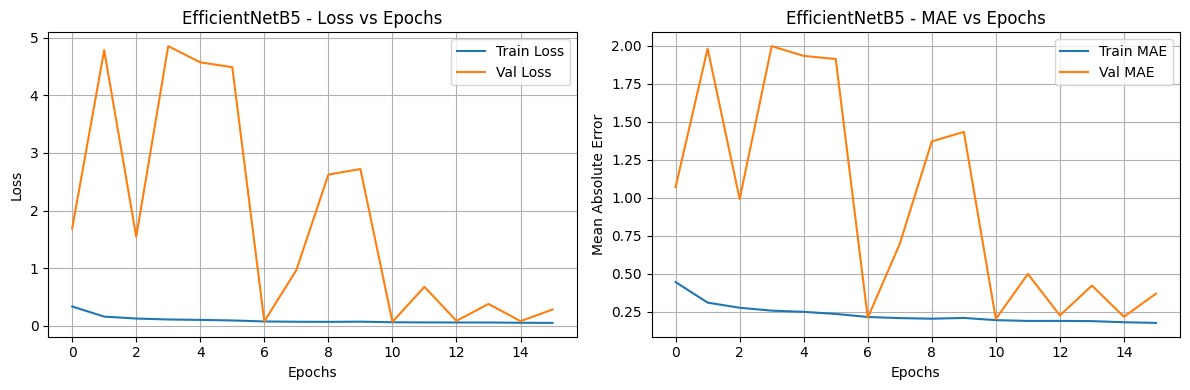

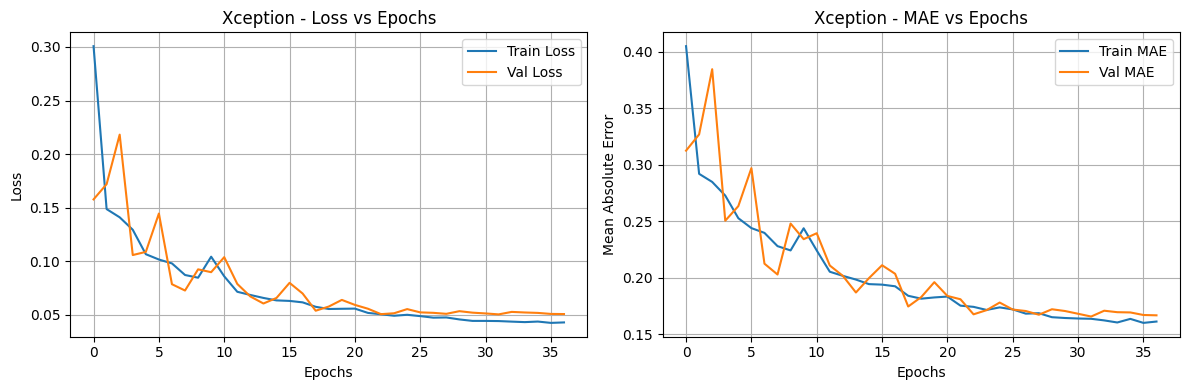

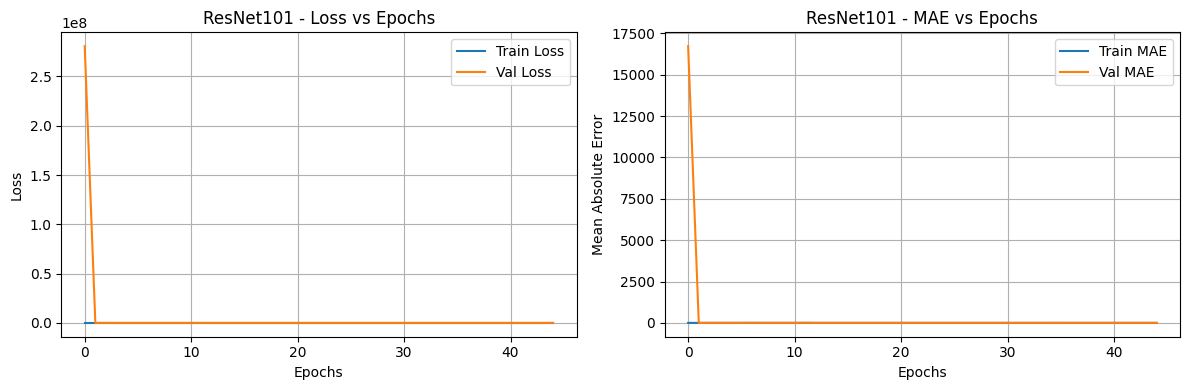

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name):
    # Plot Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'{model_name} - MAE vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example
plot_training_curves(history_eff, "EfficientNetB5")
plot_training_curves(history_xcp, "Xception")
plot_training_curves(history_res, "ResNet101")

##### Load the Models

In [ ]:
from tensorflow.keras.models import load_model

model_eff = load_model("/kaggle/input/rsna-pavan/keras/default/1/EfficientNetB5_reg.keras")  # or whatever path you used
model_res = load_model("/kaggle/input/rsna-pavan/keras/default/1/Resnet101_reg.keras")  # or whatever path you used
model_xcp = load_model("/kaggle/input/rsna-pavan/keras/default/1/Xception_reg.keras")  # or whatever path you used

I0000 00:00:1749890937.832313      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749890937.833188      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### 📊 Evaluation (Denormalized)

#### EfficientNetB5

I0000 00:00:1749891017.672792     100 service.cc:148] XLA service 0x7a17001a8ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749891017.674329     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749891017.674351     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749891019.419310     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


I0000 00:00:1749891028.764481     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


📏 MAE: 8.55 months
📏 RMSE: 11.20 months


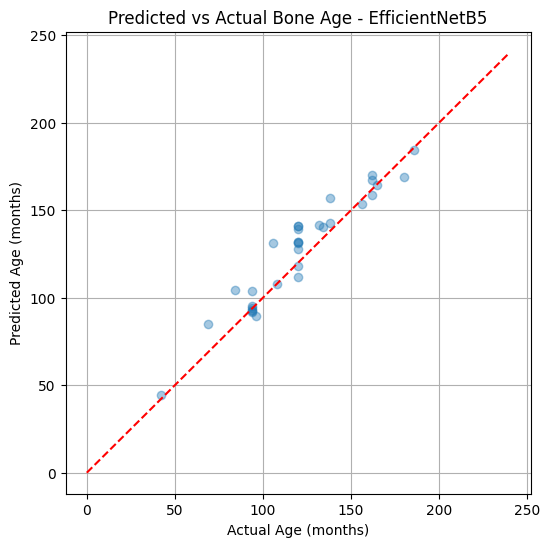

In [ ]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred_z = model_eff.predict((val_imgs, val_gender)).flatten()

# Convert z to original scale
y_pred = y_pred_z * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# MAE, RMSE
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

print(f"📏 MAE: {mae:.2f} months")
print(f"📏 RMSE: {rmse:.2f} months")

# Optional: scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age - EfficientNetB5")
plt.plot([0, 240], [0, 240], '--', color='red')
plt.grid(True)
plt.show()

#### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
📏 MAE: 6.22 months
📏 RMSE: 8.11 months


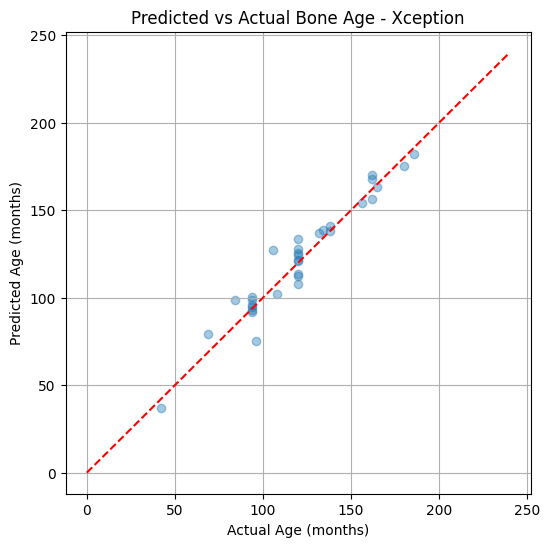

In [ ]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred_z = model_xcp.predict((val_imgs, val_gender)).flatten()

# Convert z to original scale
y_pred = y_pred_z * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# MAE, RMSE
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

print(f"📏 MAE: {mae:.2f} months")
print(f"📏 RMSE: {rmse:.2f} months")

# Optional: scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age - Xception")
plt.plot([0, 240], [0, 240], '--', color='red')
plt.grid(True)
plt.show()

#### ResNet101

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
📏 MAE: 10.11 months
📏 RMSE: 14.04 months


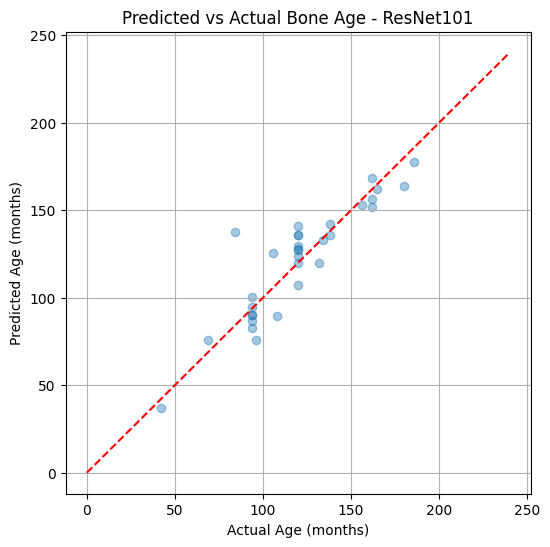

In [ ]:
# 📊 Evaluate on one batch from Validation Generator
# Correct unpacking from generator
(inputs, y_true_z) = val_gen[0]
val_imgs, val_gender = inputs

# 📈 Predict and unnormalize
y_pred_z = model_res.predict((val_imgs, val_gender)).flatten()

# Convert z to original scale
y_pred = y_pred_z * std_boneage + mean_boneage
y_true = y_true_z * std_boneage + mean_boneage

# MAE, RMSE
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

print(f"📏 MAE: {mae:.2f} months")
print(f"📏 RMSE: {rmse:.2f} months")

# Optional: scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age - ResNet101")
plt.plot([0, 240], [0, 240], '--', color='red')
plt.grid(True)
plt.show()

### 📊 Evaluation (Denormalized) - On Complete Validation Set

#### EfficientNetB5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

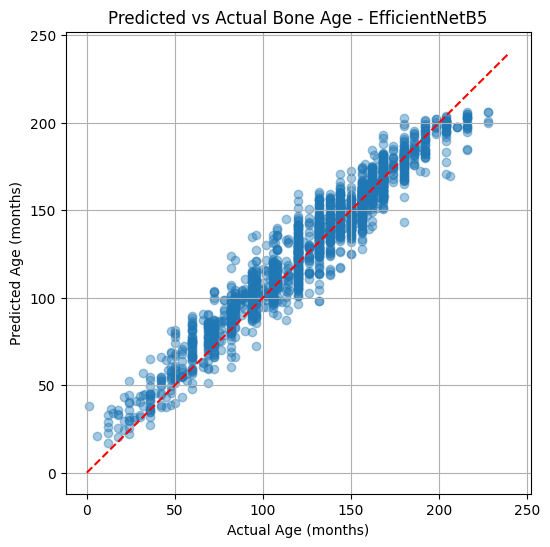

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔁 Accumulate predictions and true values for the full validation set
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model_eff.predict((imgs, genders)).flatten()

    # Unnormalize predictions and true values
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

# 📏 Convert to NumPy arrays
y_true = np.array(all_y_true)
y_pred = np.array(all_y_pred)

# 📉 Calculate metrics
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

# 🖨️ Print MAE & RMSE
print(f"📏 MAE on full validation set: {mae:.2f} months")
print(f"📏 RMSE on full validation set: {rmse:.2f} months")

# 📊 Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age - EfficientNetB5")
plt.plot([0, 240], [0, 240], '--', color='red')  # ideal diagonal
plt.grid(True)
plt.show()

#### ResNet101

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

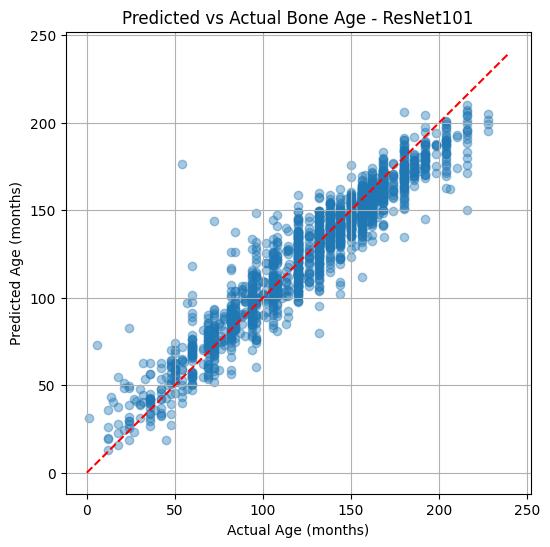

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔁 Accumulate predictions and true values for the full validation set
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model_res.predict((imgs, genders)).flatten()

    # Unnormalize predictions and true values
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

# 📏 Convert to NumPy arrays
y_true = np.array(all_y_true)
y_pred = np.array(all_y_pred)

# 📉 Calculate metrics
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

# 🖨️ Print MAE & RMSE
print(f"📏 MAE on full validation set: {mae:.2f} months")
print(f"📏 RMSE on full validation set: {rmse:.2f} months")

# 📊 Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age - ResNet101")
plt.plot([0, 240], [0, 240], '--', color='red')  # ideal diagonal
plt.grid(True)
plt.show()

#### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

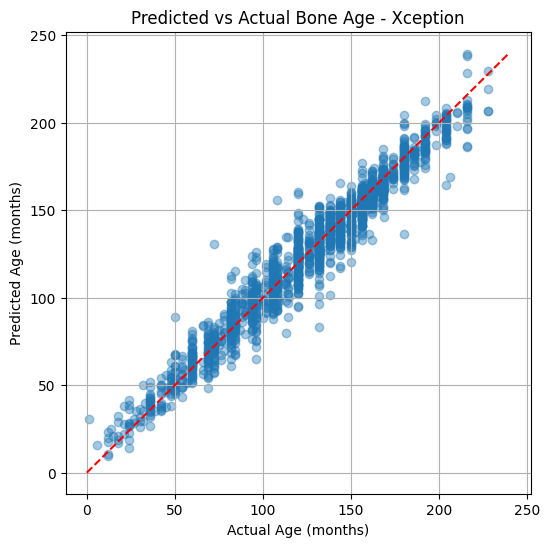

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔁 Accumulate predictions and true values for the full validation set
all_y_true = []
all_y_pred = []

for batch in range(len(val_gen)):
    (imgs, genders), y_true_batch = val_gen[batch]
    y_pred_batch = model_xcp.predict((imgs, genders)).flatten()

    # Unnormalize predictions and true values
    y_pred_batch = y_pred_batch * std_boneage + mean_boneage
    y_true_batch = y_true_batch * std_boneage + mean_boneage

    all_y_true.extend(y_true_batch)
    all_y_pred.extend(y_pred_batch)

# 📏 Convert to NumPy arrays
y_true = np.array(all_y_true)
y_pred = np.array(all_y_pred)

# 📉 Calculate metrics
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

# 🖨️ Print MAE & RMSE
print(f"📏 MAE on full validation set: {mae:.2f} months")
print(f"📏 RMSE on full validation set: {rmse:.2f} months")

# 📊 Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("Actual Age (months)")
plt.ylabel("Predicted Age (months)")
plt.title("Predicted vs Actual Bone Age - Xception")
plt.plot([0, 240], [0, 240], '--', color='red')  # ideal diagonal
plt.grid(True)
plt.show()